# CEMS-to-EIA Allocater

## Setup

In [62]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pudl
import pandas as pd
import logging
import sys
import sqlalchemy as sa
import dask.dataframe as dd

# basic setup for logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler(stream=sys.stdout)
formatter = logging.Formatter('%(message)s')
handler.setFormatter(formatter)
logger.handlers = [handler]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
pudl_settings = pudl.workspace.setup.get_defaults()
pudl_engine = sa.create_engine(pudl_settings["pudl_db"])
pudl_out = pudl.output.pudltabl.PudlTabl(pudl_engine,freq='AS')

#### Load CEMS

In [64]:
epacems_path = (pudl_settings['parquet_dir'] + f'/epacems/hourly_emissions_epacems.parquet')
cems_dd = dd.read_parquet(
    epacems_path, 
    columns=["year", "plant_id_eia", "emissions_unit_id_epa", "co2_mass_tons"],
)

In [66]:
cems_df = cems_dd.groupby(["year", "plant_id_eia", "emissions_unit_id_epa"]).sum().compute().reset_index()

In [67]:
cems_df["plant_id_eia"] = cems_df.plant_id_eia.astype("Int64")
#cems_df["co2_mass_tons"] = cems_df.co2_mass_tons.fillna(0)

#### Load EPA-EIA Crosswalk

In [68]:
crosswalk_df = pudl_out.epacamd_eia_crosswalk()

#### Load EIA Generators

In [69]:
eia_gens_df  = pudl_out.gens_eia860()

Filling technology type
Filled technology_type coverage now at 98.3%


## Pre-Integration Stats
We don't expect all of the EIA plants to show up in CEMS because not all EIA plants are subject to the EPA's reporting requirements. The EIA plants we do expect to see in CEMS:
- Burn Fossil Fuels
- Have generators with more than 25MW of capacity
- Are utility-owned
- Are not retired
- Are not old, simple combustion turbine units

In [266]:
cems_plants = cems_df.plant_id_eia.unique().tolist()
crosswalk_plants = crosswalk_df.plant_id_eia.unique().tolist()
eia_plants = eia_gens_df.plant_id_eia.unique().tolist()

print("PLANT STATS:")
print("Total CEMS plants: ", len1:=len(cems_plants))
print("CEMS plants NOT in crosswalk: ", len2:=len([x for x in cems_plants if x not in crosswalk_plants]), " = ", round(len2/len1*100), "%")
print("Total Crosswalk plants: ", len(crosswalk_plants))
print("")


crosswalk_gen_plants = crosswalk_df.drop_duplicates(subset=["plant_id_eia", "generator_id"]).set_index(["plant_id_eia", "generator_id"])
eia_gen_plants = eia_gens_df.drop_duplicates(subset=["plant_id_eia", "generator_id"]).set_index(["plant_id_eia", "generator_id"])

print("PLANT-GEN STATS:")
print("Crosswalk plant gen pairs: ", len3:=len(crosswalk_gen_plants))
print("EIA plant gen pairs: ", len4:=len(eia_gen_plants))
print("EIA plant gen pairs NOT in crosswalk: ", len5:=len(eia_gen_plants.index.difference(crosswalk_gen_plants.index)), " = ", round(len5/len4*100), "%")

PLANT STATS:
Total CEMS plants:  1831
CEMS plants NOT in crosswalk:  292  =  16 %
Total Crosswalk plants:  1542

PLANT-GEN STATS:
Crosswalk plant gen pairs:  5297
EIA plant gen pairs:  36377
EIA plant gen pairs NOT in crosswalk:  31080  =  85 %


## Merge CEMS with EIA

In [322]:
eia_gens_cems_merge = (
    eia_gens_df[["report_date", "plant_id_eia", "generator_id", "capacity_mw", "technology_description", "operational_status"]].merge(
        crosswalk_df[["plant_id_eia", "generator_id", "emissions_unit_id_epa"]], 
        how="left", 
        on=["plant_id_eia", "generator_id"])
    .assign(year=lambda x: x.report_date.dt.year.astype("Int64"))
    .merge(
        cems_df,
        how="left",
        on=["year", "plant_id_eia", "emissions_unit_id_epa"])
)

## Allocate CEMS Emissions to EIA Generators

In [316]:
def allocate_cols(
    to_allocate: pd.DataFrame, by: list, data_and_allocator_cols: dict
) -> pd.DataFrame:
    """
    Allocate larger dataset records porportionally by EIA plant-part columns.
    Args:
        to_allocate: table of data that has been merged with the EIA plant-parts
            records of the scale that you want the output to be in.
        by: columns to group by.
        data_and_allocator_cols: dict of data columns that you want to allocate (keys)
            and ordered list of columns to allocate porportionally based on. Values
            ordered based on priority: if non-null result from frist column, result
            will include first column result, then second and so on.
    Returns:
        an augmented version of ``to_allocate`` with the data columns (keys in
        ``data_and_allocator_cols``) allocated proportionally.
    """
    # add a total column for all of the allocate cols.
    all_allocator_cols = list(set(sum(data_and_allocator_cols.values(), [])))
    to_allocate.loc[:, [f"{c}_total" for c in all_allocator_cols]] = (
        to_allocate.groupby(by=by, dropna=False)[all_allocator_cols]
        .transform(sum, min_count=1)
        .add_suffix("_total")
    )
    # for each of the columns we want to allocate the frc data by
    # generate the % of the total group, so we can allocate the data_col
    to_allocate = to_allocate.assign(
        **{
            f"{col}_proportion": to_allocate[col] / to_allocate[f"{col}_total"]
            for col in all_allocator_cols
        }
    )
    # do the allocation for each of the data columns
    for data_col in data_and_allocator_cols:
        output_col = f"{data_col}_allocated"
        to_allocate.loc[:, output_col] = pd.NA
        # choose the first non-null option. The order of the allocate_cols will
        # determine which allocate_col will be used
        for allocator_col in data_and_allocator_cols[data_col]:
            to_allocate[output_col] = to_allocate[output_col].fillna(
                to_allocate[data_col] * to_allocate[f"{allocator_col}_proportion"]
            )
    # drop and rename all the columns in the data_and_allocator_cols dict keys and
    # return these columns in the dataframe
    to_allocate = (
        to_allocate.drop(columns=list(data_and_allocator_cols.keys()))
        .rename(
            columns={
                f"{data_col}_allocated": data_col
                for data_col in data_and_allocator_cols
            }
        )
        .drop(
            columns=list(to_allocate.filter(like="_proportion").columns)
            + [f"{c}_total" for c in all_allocator_cols]
        )
    )
    return to_allocate

In [323]:
eia_gens_cems_agg = (
    allocate_cols(
        to_allocate=eia_gens_cems_merge,
        by=["report_date", "plant_id_eia", "emissions_unit_id_epa"],
        data_and_allocator_cols={"co2_mass_tons": ["capacity_mw"]})
    .groupby(["report_date", "plant_id_eia", "generator_id"])
    .sum(min_count=1)
    .reset_index()
    .drop(columns=["year"])
    .merge(
        eia_gens_df[["report_date", "plant_id_eia", "generator_id", "technology_description", "operational_status"]],
        how="left",
        on=["report_date", "plant_id_eia", "generator_id"])
)

#### Test Allocation on 2020 Subset

In [278]:
test_df = eia_gens_df[(eia_gens_df["plant_id_eia"]==3) & (eia_gens_df["report_date"].dt.year==2020)]

In [279]:
test_merge = (
    test_df[["report_date", "plant_id_eia", "generator_id", "capacity_mw", "technology_description"]].merge(
        crosswalk_df[["plant_id_eia", "generator_id", "emissions_unit_id_epa"]], 
        how="left", 
        on=["plant_id_eia", "generator_id"])
    .assign(year=lambda x: x.report_date.dt.year.astype("Int64"))
    .merge(
        cems_df,
        how="left",
        on=["year", "plant_id_eia", "emissions_unit_id_epa"])
)

fake_row = test_merge.iloc[14].replace(np.nan, 0.1)
test_merge = test_merge.append(fake_row, ignore_index=True)

/var/folders/cd/6w7fpp711lsglpq_fxb57l3m0000gn/T/ipykernel_7748/1557213781.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_merge = test_merge.append(fake_row, ignore_index=True)


In [280]:
# If you want to allocate by something other than generator (plant or prive mover),
# make sure the capacity value is for that level of aggregation.

test_allocate = allocate_cols(
    to_allocate=test_merge,
    by=["report_date", "plant_id_eia", "emissions_unit_id_epa"],
    data_and_allocator_cols={"co2_mass_tons": ["capacity_mw"]}  
)

# Now sum up to generator level 
# It's very important to add min_count=1 to the groupby sum so that NA values
# Stay NA and aren't converted to 0.

# NOTE THAT RIGHT NOW if a record has a NA and non-NA value that get grouped together,
# the NA is still treated like 0. Not ideal, but it depends.

test_agg = (
    test_allocate.groupby(
        ["report_date", "plant_id_eia", "generator_id"]
    ).sum(min_count=1).reset_index().drop(columns=["year"])
)

## Post Integration Stats

In [324]:
no_cems_match = eia_gens_cems_agg[eia_gens_cems_agg["co2_mass_tons"].isna()]
cems_match = eia_gens_cems_agg[eia_gens_cems_agg["co2_mass_tons"].notna()]

### Technology Description

<AxesSubplot:>

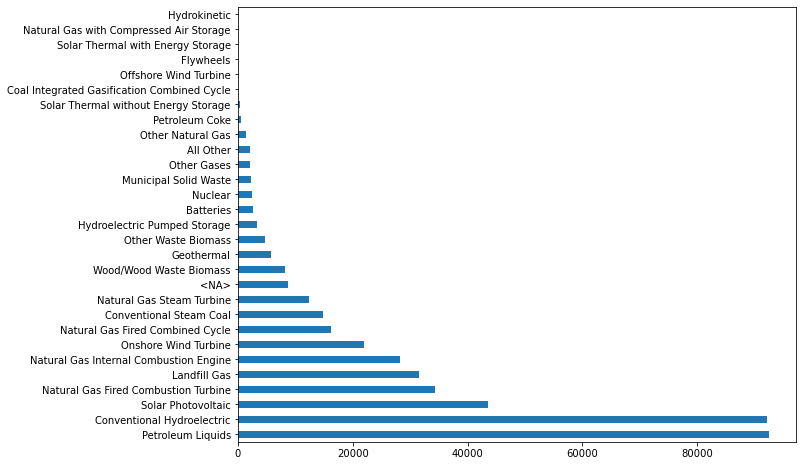

In [369]:
no_cems_match.technology_description.value_counts(dropna=False).plot(kind="barh", figsize=(10, 8))

<AxesSubplot:>

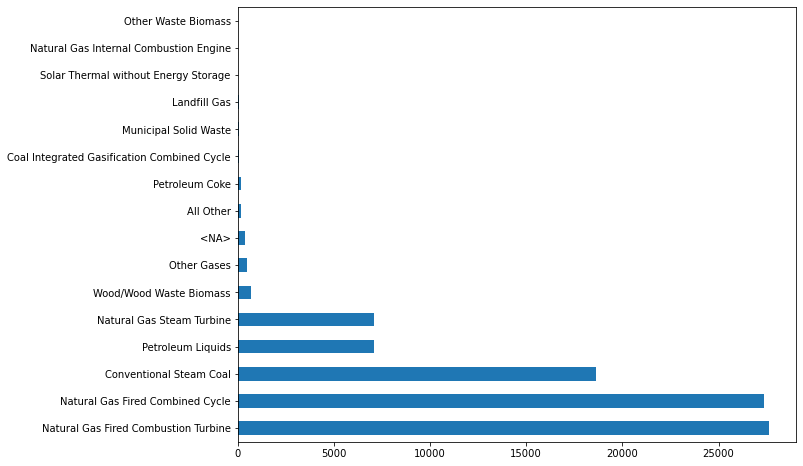

In [370]:
cems_match.technology_description.value_counts(dropna=False).plot(kind="barh", figsize=(10, 8))

### Capacity

<AxesSubplot:>

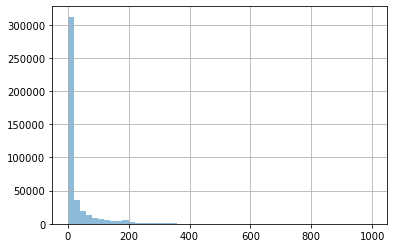

In [371]:
no_cems_match[no_cems_match["capacity_mw"] < 1000].capacity_mw.hist(bins=50, alpha=0.5)

In [374]:
no_cems_match.capacity_mw.describe()

count    433009.000000
mean         38.560670
std         115.317649
min           0.000000
25%           1.200000
50%           3.100000
75%          23.900000
max        7380.000000
Name: capacity_mw, dtype: float64

<AxesSubplot:>

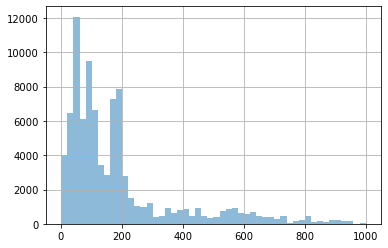

In [372]:
cems_match[cems_match["capacity_mw"] < 1000].capacity_mw.hist(bins=50, alpha=0.5)

In [375]:
cems_match.capacity_mw.describe()

count    89867.000000
mean       204.768463
std        252.371394
min          2.500000
25%         62.000000
50%        122.400000
75%        210.000000
max       7380.000000
Name: capacity_mw, dtype: float64

### Given what we know about CEMS Reporting...

In [376]:
fossil_fuels = [
     "Conventional Steam Coal",
     "Natural Gas Fired Combined Cycle",
     "Natural Gas Fired Combustion Turbine",
     "Natural Gas Steam Turbine",
     "Petroleum Liquids",
     "Natural Gas Internal Combustion Engine",
     "Municipal Solid Waste",
     "Wood/Wood Waste Biomass",
     "Coal Integrated Gasification Combined Cycle",
     "Petroleum Coke",
     "Landfill Gas",
     "Natural Gas with Compressed Air Storage",
     "Other Gases",
     "Other Waste Biomass",
     "Other Natural Gas"
]

In [391]:
exclude_exemptions = eia_gens_cems_agg[
    eia_gens_cems_agg["technology_description"].isin(fossil_fuels)
    & (eia_gens_cems_agg["capacity_mw"] > 25)
    & (eia_gens_cems_agg["operational_status"]=="existing")
]

print(100 - round(exclude_exemptions.co2_mass_tons.isna().sum() / len(exclude_exemptions) * 100), "% of existing EIA fossil fuel generators > 25MW have a CEMS match")

78 % of existing EIA fossil fuel generators > 25MW have a CEMS match


In [429]:
test = exclude_exemptions[exclude_exemptions["co2_mass_tons"].isna()].technology_description.value_counts().reset_index()
test2 = test.merge(exclude_exemptions[exclude_exemptions["co2_mass_tons"].notna()].technology_description.value_counts().reset_index(), how="outer", on=["index"], suffixes=["_isna", "_notna"])
test3 = test2.merge(exclude_exemptions.technology_description.value_counts().reset_index(), how="outer", on=["index"])

In [433]:
test3["pct_na"] = round(test3.technology_description_isna / test3.technology_description * 100)

In [436]:
test3.sort_values("pct_na", ascending=False)

,index,technology_description_isna,technology_description_notna,technology_description,pct_na
11,Natural Gas with Compressed Air Storage,22,<NA>,22,100.0
6,Municipal Solid Waste,918,48,966,95.0
9,Other Waste Biomass,86,12,98,88.0
3,Wood/Wood Waste Biomass,2457,556,3013,82.0
7,Other Gases,556,335,891,62.0
8,Petroleum Coke,194,131,325,60.0
10,Landfill Gas,28,44,72,39.0
2,Petroleum Liquids,2924,5346,8270,35.0
0,Natural Gas Fired Combustion Turbine,7220,26180,33400,22.0
12,Coal Integrated Gasification Combined Cycle,15,55,70,21.0


<AxesSubplot:>

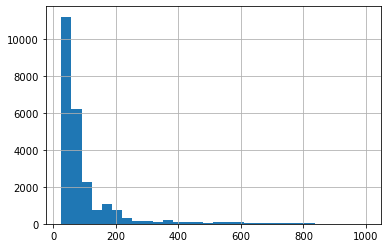

In [452]:
still_na = exclude_exemptions[exclude_exemptions["co2_mass_tons"].isna() & (exclude_exemptions["capacity_mw"]<1000)]
still_na.capacity_mw.hist(bins=30)

<AxesSubplot:>

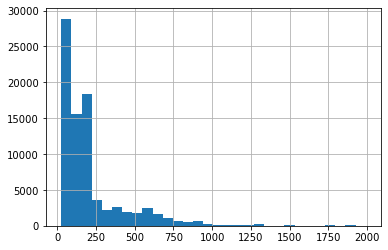

In [456]:
exclude_exemptions[exclude_exemptions["co2_mass_tons"].notna() & (exclude_exemptions["capacity_mw"]<2000)].capacity_mw.hist(bins=30)

### Time

<AxesSubplot:>

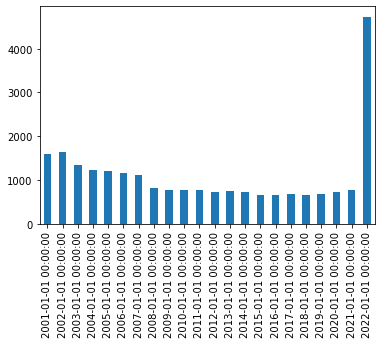

In [406]:
exclude_exemptions[exclude_exemptions["co2_mass_tons"].isna()].report_date.value_counts().sort_index().plot.bar()